<blockquote>
    <h1>Exercise 7.6</h1>
    <p>In this exercise, you will further analyze the <code>Wage</code> data set considered throughout this chapter.</p>
    <ol>
        <li>Perform polynomial regression to predict $\mathrm{wage}$ using $\mathrm{age}$. Use cross-validation to select the optimal degree $d$ for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.</li>
        <li>Fit a step function to predict $\mathrm{wage}$ using $\mathrm{age}$, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.</li>
    </ol>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%run ../../customModules/usefulFunctions.ipynb
# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut

<h3>Exercise 7.6.1</h3>
<blockquote>
    <i>Perform polynomial regression to predict $\mathrm{wage}$ using $\mathrm{age}$. Use cross-validation to select the optimal degree $d$ for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.</i>
</blockquote>

In [2]:
df = pd.read_csv("../../DataSets/Wage/Wage.csv")
df = df[['age', 'wage']]
df.head()

,age,wage
0,18,75.043154
1,24,70.476020
2,45,130.982177
3,43,154.685293
4,50,75.043154


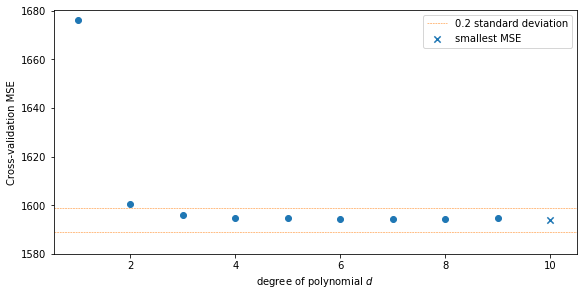

In [3]:
df_x = df[['age']]
df_x = df_x.rename(columns={'age': 'age^1'})
for i in range(2, 11):
    variable_name = 'age^' + str(i)
    df_x[variable_name] = df_x['age^1']**i

df_y = df[['wage']]
MSE = np.sum((df_y - df_y.mean().iloc[0])**2).iloc[0] / df_y.shape[0]
best_submodels = {
    0: (['Intercept'], MSE),  # null model
}

n, p = df_x.shape
features_lst = df_x.columns.tolist()
results = {}
loocv = LeaveOneOut()
for k in range(1, p + 1):
    descriptiveColumns = features_lst[:k]
    MSE = 0
    for train_index, test_index in loocv.split(df_x):
        df_x_train, df_x_test = df_x[descriptiveColumns].iloc[train_index], df_x[descriptiveColumns].iloc[test_index]
        df_y_train, df_y_test = df_y.iloc[train_index], df_y.iloc[test_index]
        
        model = LinearRegression()
        _ = model.fit(df_x_train, df_y_train)
        
        Y_pred = model.predict(df_x_test)
        MSE += (df_y_test.iloc[0, 0] - Y_pred[0, 0])**2        
    
    results[k] = MSE / n
    
degrees_lst = list(results.keys())
MSE_lst = list(results.values())
std_dev = np.std(MSE_lst)
min_mse = min(results, key=results.get)
min_val = results[min_mse]
degrees_lst.remove(min_mse)  # we plot these 'best results' with a different marker
MSE_lst.remove(min_val)  # we plot these 'best results' with a different marker


numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))
_ = ax1.scatter(degrees_lst, MSE_lst)
_ = ax1.scatter(min_mse, min_val, marker='x', s=40, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], label='smallest MSE')
_ = ax1.axhline(y=min_val - 0.2*std_dev, linestyle='dashed', linewidth=0.5, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], label='0.2 standard deviation')
_ = ax1.axhline(y=min_val + 0.2*std_dev, linestyle='dashed', linewidth=0.5, c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
_ = ax1.set_xlabel(r'degree of polynomial $d$')
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.legend()
_ = ax1.set_ylim(ymin = 1580)

<p>Although the polynomial of degree $10$ gives the smallest test MSE, we choose $d=3$ as the optimal degree because its associated test MSE is almost the same as for $d=10$ while it is a much simpler model.<p>

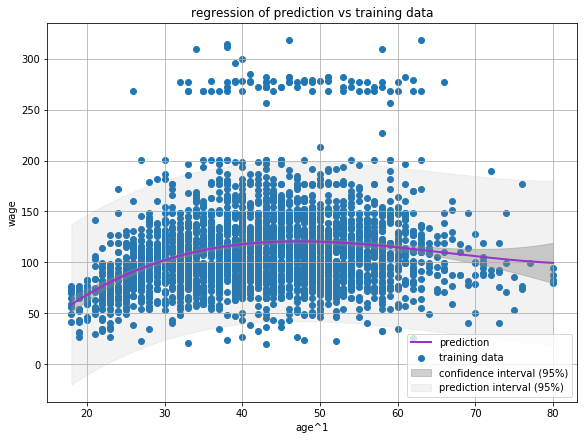

In [4]:
df_x_withIntercept = df_x[['age^1', 'age^2', 'age^3']].copy()
df_x_withIntercept.insert(0, 'Intercept', 1)
fitted = sm.OLS(df_y, df_x_withIntercept).fit()

polynomialMap = {
    'age^1': 1,
    'age^2': 2,
    'age^3': 3,
}
createPolynomialLinearRegressionPlot(df_x_withIntercept[['Intercept', 'age^1', 'age^2', 'age^3']], df_y, fitted_model=fitted, height=6, width=8, polynomialMap=polynomialMap)

In [5]:
# ANOVA
df_x_withIntercept = df_x.copy()
df_x_withIntercept.insert(0, 'Intercept', 1)
models = {}
descriptiveColumns = ['Intercept']
columns = df_x.columns
for column in columns:
    descriptiveColumns += [column]
    fitted = sm.OLS(df_y, df_x_withIntercept[descriptiveColumns]).fit()
    models[column] = fitted

df_anova = sm.stats.anova_lm(*models.values())
df_anova.rename(columns={'df_resid': 'dof of residuals', 'ssr': 'RSS', 
                         'df_diff': 'dof difference',
                         'ss_dff': 'RSS difference', 
                         'F': 'F-statistic'}, inplace=True)
df_anova

/home/floris/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/floris/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/floris/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,dof of residuals,RSS,dof difference,ss_diff,F-statistic,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.234621,2.808148e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.864068,1.701809e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.800302,5.133655e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.802966,3.702800e-01
5,2993.0,4.766389e+06,1.0,3932.257631,2.461844,1.167475e-01
6,2993.0,4.764599e+06,-0.0,1790.494628,-inf,NaN
7,2993.0,4.764136e+06,-0.0,462.435544,-inf,NaN
8,2993.0,4.764981e+06,-0.0,-844.242937,inf,NaN
9,2993.0,4.780664e+06,-0.0,-15682.793682,inf,NaN


<p>The $p$ values of the ANOVA summary show that any model with $d > 3$ is statistically insignificant with a significance level of $\alpha = 10 \%$.</p>

<h3>Exercise 7.6.2</h3>
<blockquote>
    <i>Fit a step function to predict $\mathrm{wage}$ using $\mathrm{age}$, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.</i>
</blockquote>

/home/floris/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


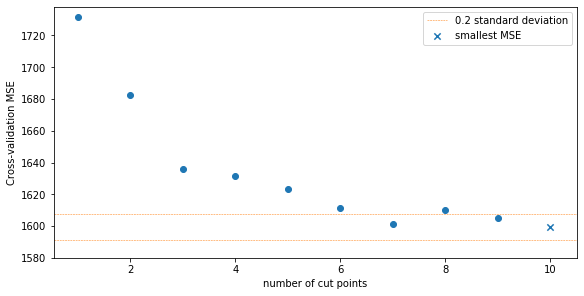

In [6]:
_ = stepFunctionChooseOptimalCuts(df_x[['age^1']], df_y, total_cuts=10)

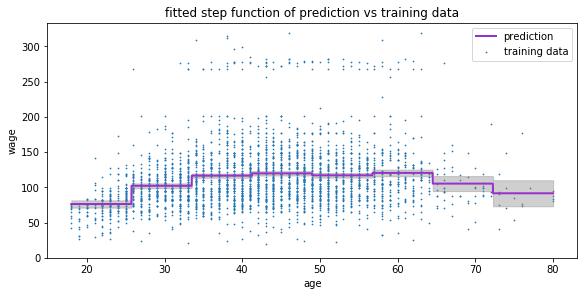

In [7]:
plotFittedStepFunction(df_x[['age^1']].rename(columns={'age^1': 'age'}), 
                       df_y, cuts_best=7)